# Análise do número de itens e número de itens com comprovantes de projetos culturais
---

Issue: [#199](https://github.com/lappis-unb/salic-ml/issues/199) Explorar nova métrica: razão entre o número de itens com comprovante e o número de itens por projeto.

## Objetivos

Analisar a razão entre o número de itens com comprovantes e o número total de itens de todos os projetos culturais, sem delimitações de segmento ou produto cultural. Nesta análise, serão utilizados modelos para identificar projetos onde tal métrica é anormal com relação aos demais projetos.

A metodolgia e modelos aplicados neste notebook para identificar projetos considerados anômalos com relação a esta métrica é a mesma aplicada no notebook `notebooks/report/analysis_of_approved_funds.ipynb`, relativo à métrica "valor total aprovado para um projeto".

---
## Preparação

Será gerado um dataset contendo as informações abaixo relativas a cada produto cultural de cada projeto que tenha pelo menos um comprovante. Optou-se por gerar os dados identificados por produto e projeto para posterior utilização dos dados, contudo, neste notebook serão utilizados tais dados identificados apenas pelo projeto.
* Número de itens
* Número de itens com comprovantes
* Número de comprovantes
* Dados derivados dos três acima

#### Importando módulos necessários

In [1]:
%pylab inline
import scipy
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


#### 1. Carregando dataset que relaciona projetos com seus respectivos itens

In [2]:
df_budget = pd.read_csv('../../data/raw/planilha_orcamentaria.csv')
print(df_budget.columns)
df_budget.head()

Index(['idPronac', 'PRONAC', 'idPlanilhaAprovacao', 'Item', 'idPlanilhaItens',
       'Unidade', 'QtDias', 'QtItem', 'nrOcorrencia', 'VlUnitarioSolicitado',
       'VlTotalSolicitado', 'VlUnitarioAprovado', 'VlTotalAprovado', 'UfItem',
       'MunicipioItem', 'Etapa', 'idArea', 'Area', 'idSegmento', 'Segmento',
       'idProduto', 'Produto', 'DataProjeto', 'cdCidade', 'cdEtapa'],
      dtype='object')


,idPronac,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,Unidade,QtDias,QtItem,nrOcorrencia,VlUnitarioSolicitado,...,Etapa,idArea,Area,idSegmento,Segmento,idProduto,Produto,DataProjeto,cdCidade,cdEtapa
0,121051,100855,792860,Passagens Aéreas (Descrever os trechos na tela...,131,Unidade,150,40.0,1.0,150.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,330455,2
1,121051,100855,792883,Bonecos – Criação,3599,Verba,90,1.0,1.0,4000.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,330455,2
2,121051,100855,792903,Produtor executivo,53,Verba,90,3.0,1.0,3000.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,355030,2
3,119968,98671,109095,Assistente de produção,1037,Verba,30,1.0,1.0,1000.0,...,1 - Pré-Produção / Preparação,3,Música,31,Música Popular Cantada,51,Apresentação Musical,2009-12-28 11:37:57.830,330455,1
4,112836,91695,116511,Designer,103,Mês,378,1.0,18.0,2000.0,...,2 - Produção / Execução,7,Artes Integradas,71,Artes Integradas,17,Pesquisa,2009-05-21 10:48:48.790,431490,2


#### Visualizando amostra de produtos culturais

In [3]:
products = df_budget[['idProduto', 'Produto', 'PRONAC']].drop_duplicates()
products = products.groupby(['idProduto', 'Produto']).count()
products = products.rename(columns={'PRONAC' : 'numOccurrences'})
products = products.sort_values(by='numOccurrences', ascending=False)
print(products.shape)
products.head()

(75, 1)


,,numOccurrences
idProduto,Produto,
0,Administracao do Projeto,41568
19,Espetáculo de Artes Cênicas,10360
51,Apresentação Musical,8338
1,Livro,6476
18,Festival/Mostra,4944


#### Extraindo a relação de itens de projetos

In [4]:
projects = df_budget[['idProduto', 'idPlanilhaItens', 'PRONAC']].drop_duplicates()
projects = projects.set_index(['PRONAC', 'idPlanilhaItens'])
print(projects.shape)
projects.head()

(1673527, 1)


idProduto
PRONAC idPlanilhaItens           
100855 131                     19
       3599                    19
       53                      19
98671  1037                    51
91695  103                     17

#### 2. Carregando dataset que relaciona itens de projetos com seus respetivos comprovantes

In [5]:
df_receipts = pd.read_csv('../../data/raw/planilha_comprovacao.csv', low_memory=False)
print(df_receipts.columns)
df_receipts.head()

Index(['PRONAC', 'idPlanilhaAprovacao', 'idComprovantePagamento', 'IdPRONAC',
       'idSegmento', 'cdProduto', 'cdEtapa', 'cdUF', 'UF', 'cdCidade',
       'idPlanilhaItem', 'Item', 'DataProjeto', 'nrComprovante', 'nrSerie',
       'nrCNPJCPF', 'nmFornecedor', 'proponenteCgcCpf', 'tpDocumento',
       'dtPagamento', 'dtEmissao', 'tpFormaDePagamento',
       'nrDocumentoDePagamento', 'idArquivo', 'dsJustificativaProponente',
       'dsOcorrenciaDoTecnico', 'stItemAvaliado', 'stAvaliacao',
       'vlComprovacao'],
      dtype='object')


,PRONAC,idPlanilhaAprovacao,idComprovantePagamento,IdPRONAC,idSegmento,cdProduto,cdEtapa,cdUF,UF,cdCidade,...,dtPagamento,dtEmissao,tpFormaDePagamento,nrDocumentoDePagamento,idArquivo,dsJustificativaProponente,dsOcorrenciaDoTecnico,stItemAvaliado,stAvaliacao,vlComprovacao
0,1012121,18552,4326,132451,71,1,1,35,SP,355030,...,2014-01-16 00:00:00,2013-03-27 00:00:00,Transferencia Bancaria,42501,410880,Elaboração de projeto gráfico do livro.,NaN,4,Aguardando analise,12000.0
1,1012121,18553,4332,132451,71,1,2,35,SP,355030,...,2014-01-16 00:00:00,2012-04-30 00:00:00,Transferencia Bancaria,2945,410935,Reportagem e produção de textos para livro.,NaN,4,Aguardando analise,6000.0
2,1012121,18554,4755,132451,71,1,2,35,SP,355030,...,2014-01-28 00:00:00,2012-03-16 00:00:00,Transferencia Bancaria,31601,420731,Fotografia artística para o livro.,NaN,4,Aguardando analise,12000.0
3,1012121,18555,4334,132451,71,1,2,35,SP,355030,...,2014-01-16 00:00:00,2013-08-27 00:00:00,Transferencia Bancaria,90201,410939,Tratamento de imagens para o livro.,NaN,4,Aguardando analise,6000.0
4,1012121,18556,4327,132451,71,1,2,35,SP,355030,...,2014-01-16 00:00:00,2012-05-04 00:00:00,Transferencia Bancaria,2945,410917,Edição dos textos do livro.,NaN,4,Aguardando analise,8000.0


#### Extraindo os comprovantes identificados por item e projeto

In [6]:
receipts = df_receipts[['PRONAC', 'idComprovantePagamento', 'idPlanilhaItem']].drop_duplicates()
receipts = receipts.rename(columns={'idPlanilhaItem': 'idPlanilhaItens'})
receipts = receipts.set_index(['PRONAC', 'idPlanilhaItens'])
print(receipts.shape)
receipts.head()

(355659, 1)


idComprovantePagamento
PRONAC  idPlanilhaItens                        
1012121 43                                 4326
        91                                 4332
        143                                4755
        3204                               4334
        97                                 4327

#### 3. Gerando dataset contendo os dados do ID do projeto/produto e seu número de comprovantes

In [7]:
projects_receipts = receipts.join(projects)
projects_receipts = projects_receipts.groupby(['idProduto', 'PRONAC']).count()
projects_receipts = projects_receipts.rename(columns={'idComprovantePagamento': 'numReceipts'})
print(projects_receipts.shape)
projects_receipts.head()

(6766, 1)


numReceipts
idProduto PRONAC             
0.0       110107            4
          110131            5
          110152            1
          110170            3
          110283            9

#### 4. Gerando dataset contendo o número de itens com comprovante para cada projeto e produto cultural

In [8]:
items_w_receipts = receipts.reset_index().drop_duplicates(subset=['PRONAC', 'idPlanilhaItens'])
items_w_receipts = items_w_receipts[['PRONAC', 'idPlanilhaItens']]
items_w_receipts = items_w_receipts.set_index(['PRONAC', 'idPlanilhaItens'])
items_w_receipts = items_w_receipts.join(projects)
items_w_receipts = items_w_receipts.reset_index(level='idPlanilhaItens')
items_w_receipts = items_w_receipts.groupby(['idProduto', 'PRONAC']).count()
items_w_receipts = items_w_receipts.rename(columns={'idPlanilhaItens': 'numItemsWithReceipts'})
print(items_w_receipts.shape)
items_w_receipts.head()

(6766, 1)


numItemsWithReceipts
idProduto PRONAC                      
0.0       110107                     2
          110131                     5
          110152                     1
          110170                     1
          110283                     4

#### 5. Gerando dataset contendo os dados do produto cultural, identificador do projeto e seu número de itens

In [9]:
projects_items = df_budget[['idProduto', 'PRONAC', 'idPlanilhaItens']]
projects_items = projects_items.groupby(['idProduto', 'PRONAC']).count()
projects_items = projects_items.rename(columns={'idPlanilhaItens': 'numItems'})
print(projects_items.shape)
projects_items.head()

(106002, 1)


numItems
idProduto PRONAC          
0         90105          6
          90226         11
          90335         11
          90413         14
          90722          9

#### 6. Gerando dataset final contendo o número de itens e o número de comprovantes para um dado projeto e produto cultural

Neste passo, todos os projetos sem nenhum comprovante são descartados.

In [10]:
pri = projects_receipts.join(items_w_receipts).join(projects_items)
pri['receiptsItemsRatio'] = pri['numReceipts'] / pri['numItems']
pri['itemswreceiptsItemsRatio'] = pri['numItemsWithReceipts'] / pri['numItems']
projects_receipts_items = pri
print(projects_receipts_items.shape)
projects_receipts_items.head()

(6766, 5)


numReceipts  numItemsWithReceipts  numItems  \
idProduto PRONAC                                                
0.0       110107            4                     2         7   
          110131            5                     5        14   
          110152            1                     1        11   
          110170            3                     1         6   
          110283            9                     4        11   

                  receiptsItemsRatio  itemswreceiptsItemsRatio  
idProduto PRONAC                                                
0.0       110107            0.571429                  0.285714  
          110131            0.357143                  0.357143  
          110152            0.090909                  0.090909  
          110170            0.500000                  0.166667  
          110283            0.818182                  0.363636

---
## Desenvolvimento

#### Gerando uma lista da razão entre o número de itens com comprovante e o número de itens de projetos

In [11]:
projects = projects_receipts_items.reset_index(level='idProduto')['itemswreceiptsItemsRatio']
print(projects.dropna().shape)
display(projects.head())

(6766,)


PRONAC
110107    0.285714
110131    0.357143
110152    0.090909
110170    0.166667
110283    0.363636
Name: itemswreceiptsItemsRatio, dtype: float64

#### Gerando visualizações dos dados acima

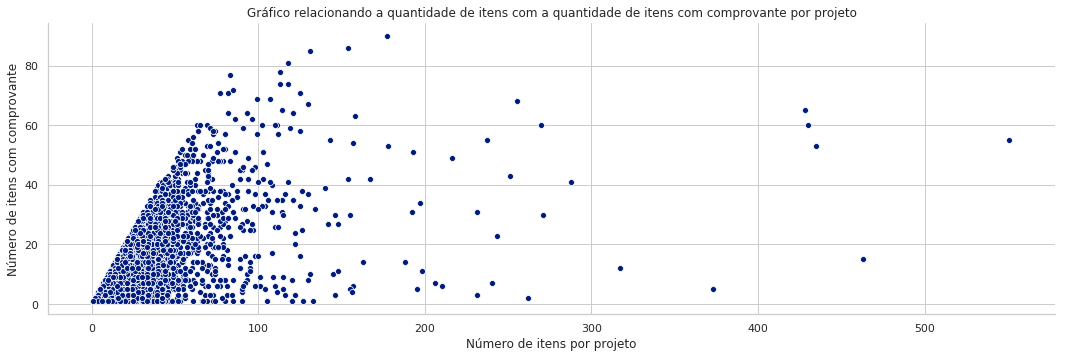

In [12]:
sns.set(style='whitegrid', palette='dark')
sns.relplot(x='numItems', y='numItemsWithReceipts', data=projects_receipts_items, aspect=3)
plt.xlabel('Número de itens por projeto')
plt.ylabel('Número de itens com comprovante')
plt.title('Gráfico relacionando a quantidade de itens com a quantidade de itens com comprovante por projeto');

Média da distribuição: 0.61
Desvio padrão da distribuição: 0.29



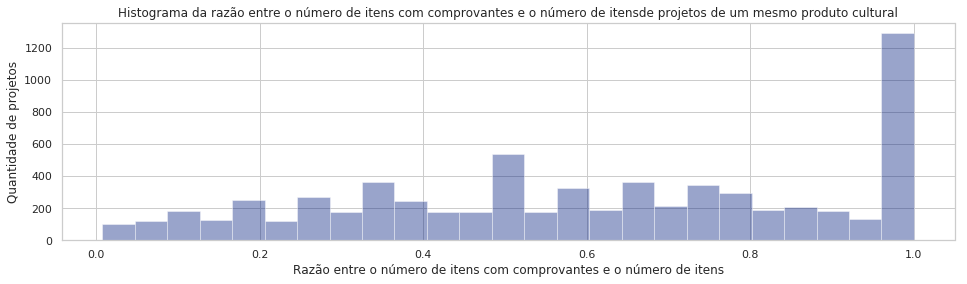

In [13]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

sns.distplot(projects, bins=25, kde=False)
plt.title('Histograma da razão entre o número de itens com comprovantes e o número de itens' +
          'de projetos de um mesmo produto cultural')
plt.ylabel('Quantidade de projetos')
plt.xlabel('Razão entre o número de itens com comprovantes e o número de itens')
plt.grid(True)

expected_mean = np.mean(projects)
expected_std = np.std(projects)

print('Média da distribuição: %.2lf' % expected_mean)
print('Desvio padrão da distribuição: %.2lf\n' % expected_std)

#### Separando os conjuntos de treino e teste

In [14]:
from sklearn.model_selection import train_test_split
projects_train, projects_test = train_test_split(projects, test_size=0.3)

display(projects_train.head())
display(projects_test.head())

PRONAC
148852    1.000000
138238    0.101695
145647    1.000000
161302    0.600000
125360    0.325000
Name: itemswreceiptsItemsRatio, dtype: float64

PRONAC
164880     0.555556
1413905    0.750000
1413908    0.666667
164084     0.666667
150823     0.631579
Name: itemswreceiptsItemsRatio, dtype: float64

#### Implementando função auxiliar para mostrar os gráficos e estatísticas referentes a cada um dos modelos explorados

In [15]:
import time
def show_stats(model, train_set, test_set, bin_size=1):
    begin = time.time()
    model.fit(train_set)
    print('Tempo de treinamento: %.3lf (s)' % (time.time() - begin))
    begin = time.time()
    is_inlier = model.predict(test_set)
    print('Tempo de teste: %.3lf (s)' % (time.time() - begin))

    contamination_found = sum(~is_inlier) / len(test_set)
    print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
    print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

    sns.set(style='whitegrid', palette='dark')
    f, ax = plt.subplots(figsize=(16,4))

    inliers = test_set[is_inlier]
    bins = max(1, int((max(inliers) - min(inliers)) // bin_size) + 1)
    sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

    outliers = test_set[~is_inlier]
    bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
    sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)
    
    if hasattr(model.model, 'pdf'):
        x = np.linspace(min(test_set), max(test_set), 1000)
        y = model.model.pdf(x)
        if hasattr(model, 'transform'):
            y = model.model.pdf(model.transform(x))
        plt.plot(x,  bin_size * len(test_set) * y, label='PDF')

    plt.legend(frameon=True)
    plt.ylabel('# projects')
    plt.xlabel('numItemsWReceipts / numItems')
    plt.title('Inlier/Outlier division')

#### Implementando funções auxiliares para os modelos utilizados

In [16]:
def bisect(f, a=0, b=1, rtol=1e-6, maxiter=40):
    # simplified scipy.optimize.bisect
    niter, x0 = (0, a)
    while niter < maxiter:
        niter += 1
        x0 = (b + a) / 2
        f0 = f(x0)
        if abs(f0) < rtol:
            break
        elif f0 < 0:
            b = x0
        else:
            a = x0
    return x0

def find_threshold(model, X, contamination):
    h = max(X) - min(X)
    _X = np.linspace(min(X) - h, max(X) + h, int(1e3))
    dx = _X[1] - _X[0]
    pdf = model.pdf(_X)
    def f(threshold):
        _pdf = pdf.copy()
        _pdf[_pdf <= threshold] = 0
        I = scipy.integrate.simps(_pdf, dx=dx)
        return I - (1.0 - contamination)
    return bisect(f)

#### Modelo Gaussiano

Tempo de treinamento: 0.016 (s)
Tempo de teste: 0.001 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 5.62%


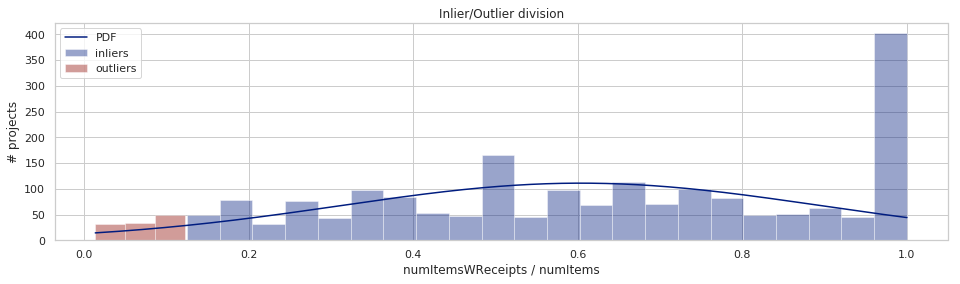

In [17]:
class Gaussian:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X):
        # Generate model
        mean, std = scipy.stats.norm.fit(X)
        self.model = scipy.stats.norm(mean, std)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Gaussian(), projects_train, projects_test, bin_size=0.04)

#### Modelo Log-normal

Tempo de treinamento: 0.166 (s)
Tempo de teste: 0.002 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 1.28%


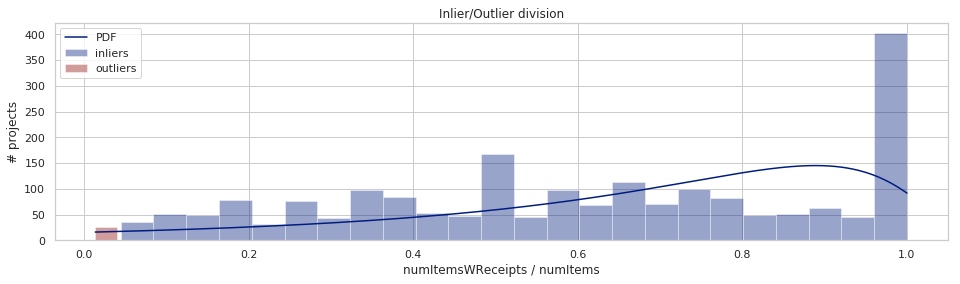

In [18]:
class Lognormal:
    def __init__(self, contamination=0.1, transform=None):
        self.contamination = contamination
        self.transform = transform

    def fit(self, X):
        # Generate model
        if self.transform:
            X = self.transform(X)
        s, loc, scale = scipy.stats.lognorm.fit(X, floc=0)
        self.model = scipy.stats.lognorm(np.std(np.log(X)), loc=loc, scale=scale)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Lognormal(transform=lambda X: 1.1-X), projects_train, projects_test, bin_size=0.04)

#### Modelo Gamma

Tempo de treinamento: 0.022 (s)
Tempo de teste: 0.002 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 2.56%


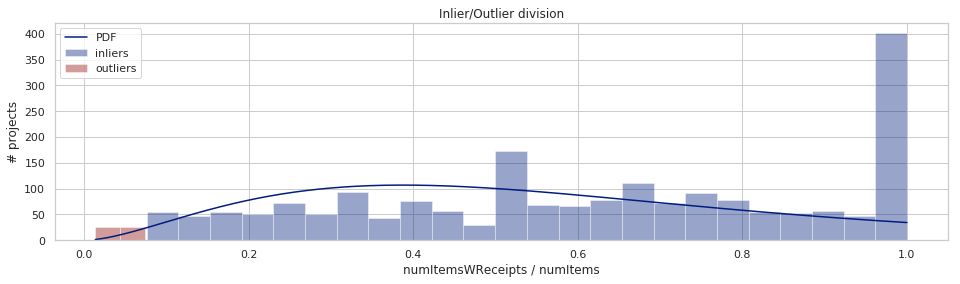

In [19]:
class Gamma:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X):
        # Generate model
        params = scipy.stats.gamma.fit(X, floc=0)
        self.model = scipy.stats.gamma(*params)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(Gamma(), projects_train, projects_test, bin_size=0.04)

#### Modelo de Estimativa de Densidade Kernel com Kernel Gaussiano

Tempo de treinamento: 0.578 (s)
Tempo de teste: 1.209 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 7.88%


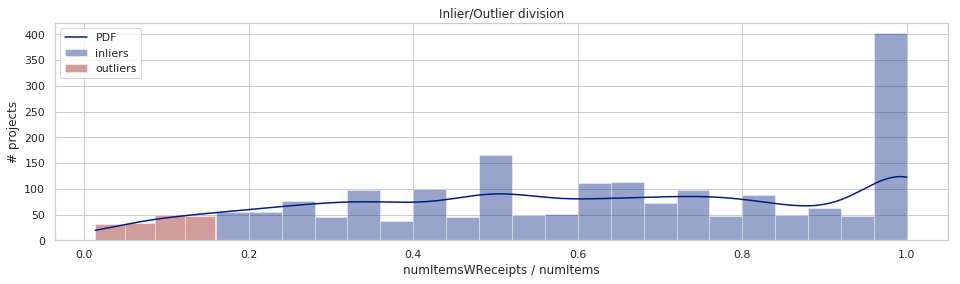

In [20]:
class KDE:
    def __init__(self, contamination=0.1, kernel='gauss'):
        self.contamination = contamination
        self.kernel = kernel

    def fit(self, X):
        # Generate model
        if self.kernel == 'gauss':
            self.model = scipy.stats.gaussian_kde(X)
        else:
            raise AttributeError('Kernel function not found')
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(KDE(), projects_train, projects_test, bin_size=0.04)

#### Estimador por Fator de Anomalia Local (LOF)

Tempo de treinamento: 0.134 (s)
Tempo de teste: 0.027 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 26.80%


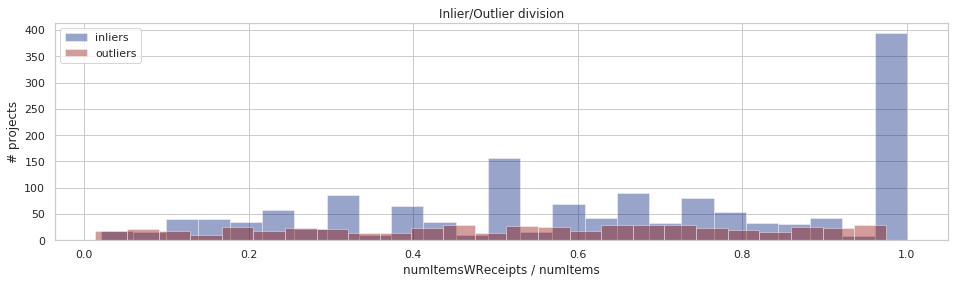

In [21]:
from sklearn.neighbors import LocalOutlierFactor
class LOF:
    def __init__(self, contamination=0.1, n_neighbors=20):
        self.contamination = contamination
        self.n_neighbors = n_neighbors

    def fit(self, X):
        # Transform data into a 2D array
        X = self._1Dto2D(X)
        # Get inliers of the training set with LOF Outlier Detection
        lof_OD = LocalOutlierFactor(contamination=self.contamination,
                                    n_neighbors=self.n_neighbors)
        y = lof_OD.fit_predict(X)
        X = X[y == 1, :]
        # Train model with LOF Novelty Detection, using train set inliers
        # Parameter 'contamination' does not matter at this point
        self.model = LocalOutlierFactor(novelty=True, contamination=0.5)
        self.model = self.model.fit(X)
        return self
    
    def predict(self, X):
        X = self._1Dto2D(X)
        is_inlier = (self.model.predict(X) == 1)
        return is_inlier
    
    def _1Dto2D(self, X):
        shape = (len(X),1)
        return np.hstack([np.array(X.tolist()).reshape(shape), np.zeros(shape)])

show_stats(LOF(), projects_train, projects_test, bin_size=0.04)

#### Avaliando a contaminação média encontrada

Nesta seção, os diversos modelos implementados acima são aplicados a várias escolhas aleatórias de conjuntos de treino/teste. Ao final, o desempenho de cada modelo é avaliado.

In [22]:
models = [{
    'name': 'Gaussian',
    'curve': Gaussian(),
    'results': []
},{
    'name': 'Log-normal',
    'curve': Lognormal(transform=lambda X: 1.1-X),
    'results': []
},{
    'name': 'Gamma',
    'curve': Gamma(),
    'results': []
},{
    'name': 'KDE-Gauss',
    'curve': KDE(),
    'results': []
},{
    'name': 'LOF',
    'curve': LOF(),
    'results': []
}]

for i in range(20):
    # Separate train and test sets
    projects_train, projects_test = train_test_split(projects, test_size=0.3)
    
    # Get results for each model
    for model in models:
        inlier_filter = (model['curve'].fit(projects_train).predict(projects_test))
        contamination_found = sum(~inlier_filter) / len(projects_test)
        model['results'].append(100 * contamination_found)

Média Gaussian: 5.52%
Média Log-normal: 1.21%
Média Gamma: 2.71%
Média KDE-Gauss: 7.33%
Média LOF: 25.36%


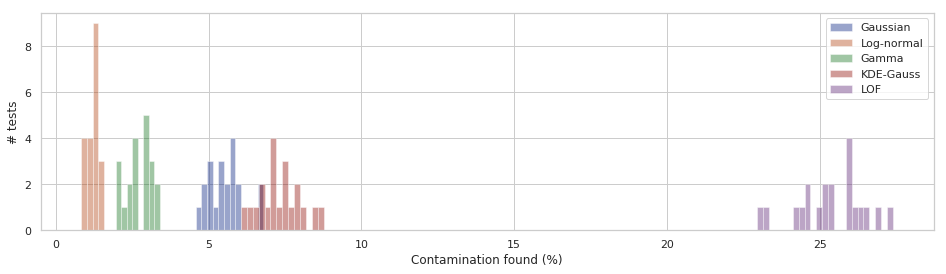

In [23]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 0.2
for model in models:
    results = model['results']
    print('Média %s: %.2lf%%' % (model['name'], np.mean(results)))
    bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
    sns.distplot(results, label=model['name'], kde=False, bins=bins)

plt.legend(frameon=True)
plt.xlabel('Contamination found (%)')
plt.ylabel('# tests')
plt.grid(True)

---
## Resultados e Conclusões

O modelo de Distribuição KDE apresentou os melhores resultados em termos de acurácia, contudo, os piores em termos de desempenho. O modelo Gaussiano obteve o segundo melhor resultado em acurácia, porém, foi o mais rápido entre todos os utilizados, chegando a ser 40 vezes mais rápido queo KDE na etapa de treinamento e 1000 vezes mais rápido na etapa de teste. Desta forma, ambos os modelos são válidos a serem utilizados.

Os modelos Log-Normal e Gamma apresentaram taxas médias de contaminação muito baixas e assim, não são adequados para o contexto. O modelo LOF apresentou uma taxa de contaminação muito elevada e rotulou valores altos de "razão de número itens com comprovantes por número de itens" como outliers, o que não parece fazer sentido para o contexto.